In [1]:
from itertools import combinations
import numpy as np
import scipy as sp
from scipy.constants import c, h,Stefan_Boltzmann as st
from scipy.interpolate import make_interp_spline
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('CorpoNero.txt', names=['vl', 'il', 'vpd', 'fs'], skiprows=1)
df['err_vl']=1e-2
df['err_il']=1e-2
df['err_vpd']=np.array([1e-2]*7+[1e-3]*8+[1e-4]*8)
df['potenza']=df['vl']*df['il']
df['err_p']=np.sqrt((df['il']*df['err_vl'])**2 + (df['vl']*df['err_il'])**2)

In [3]:
df

,vl,il,vpd,fs,err_vl,err_il,err_vpd,potenza,err_p
0,14.97,5.98,3.2300,20.0,0.01,0.01,0.0100,89.5206,0.161202
1,14.46,5.86,2.7600,20.0,0.01,0.01,0.0100,84.7356,0.156023
2,13.96,5.75,2.3500,20.0,0.01,0.01,0.0100,80.2700,0.150978
3,13.47,5.64,2.0200,20.0,0.01,0.01,0.0100,75.9708,0.146031
4,12.99,5.52,1.7100,20.0,0.01,0.01,0.0100,71.7048,0.141142
5,12.49,5.41,1.4400,20.0,0.01,0.01,0.0100,67.5709,0.136113
6,12.00,5.29,1.2000,20.0,0.01,0.01,0.0100,63.4800,0.131143
7,11.55,5.19,1.0580,2.0,0.01,0.01,0.0010,59.9445,0.126625
8,10.98,5.03,0.8280,2.0,0.01,0.01,0.0010,55.2294,0.120773
9,10.44,4.90,0.6480,2.0,0.01,0.01,0.0010,51.1560,0.115327


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vl       23 non-null     float64
 1   il       23 non-null     float64
 2   vpd      23 non-null     float64
 3   fs       23 non-null     float64
 4   err_vl   23 non-null     float64
 5   err_il   23 non-null     float64
 6   err_vpd  23 non-null     float64
 7   potenza  23 non-null     float64
 8   err_p    23 non-null     float64
dtypes: float64(9)
memory usage: 1.7 KB


In [5]:
df=df[df['vpd']> df['vpd'].quantile(0.15)]

In [6]:
df.describe()

,vl,il,vpd,fs,err_vl,err_il,err_vpd,potenza,err_p
count,19.000000,19.000000,19.000000,19.000000,1.900000e+01,1.900000e+01,19.000000,19.000000,19.000000
mean,10.492105,4.870000,1.015195,8.252632,1.000000e-02,1.000000e-02,0.004126,53.038753,0.115791
std,2.799489,0.733303,0.983478,9.244059,1.782259e-18,1.782259e-18,0.004622,21.267585,0.028437
min,5.980000,3.610000,0.053000,0.200000,1.000000e-02,1.000000e-02,0.000100,21.587800,0.069852
25%,8.230000,4.295000,0.212000,2.000000,1.000000e-02,1.000000e-02,0.001000,35.362800,0.092834
50%,10.440000,4.900000,0.648000,2.000000,1.000000e-02,1.000000e-02,0.001000,51.156000,0.115327
75%,12.740000,5.465000,1.575000,20.000000,1.000000e-02,1.000000e-02,0.010000,69.637850,0.138628
max,14.970000,5.980000,3.230000,20.000000,1.000000e-02,1.000000e-02,0.010000,89.520600,0.161202


In [7]:
t0 = np.linspace(300.0, 3600.0, 34)
e0 = np.array([0.032, 0.042, 0.053, 0.064, 0.076, 0.088, 0.101, 0.114, 0.128,
                   0.143, 0.158, 0.175, 0.192, 0.207, 0.222, 0.236, 0.249, 0.260,
                   0.270, 0.279, 0.288, 0.296, 0.303, 0.311, 0.318, 0.323, 0.329,
                   0.334, 0.337, 0.341, 0.344, 0.348, 0.351, 0.354])
emissività = make_interp_spline(t0, e0, k=1)

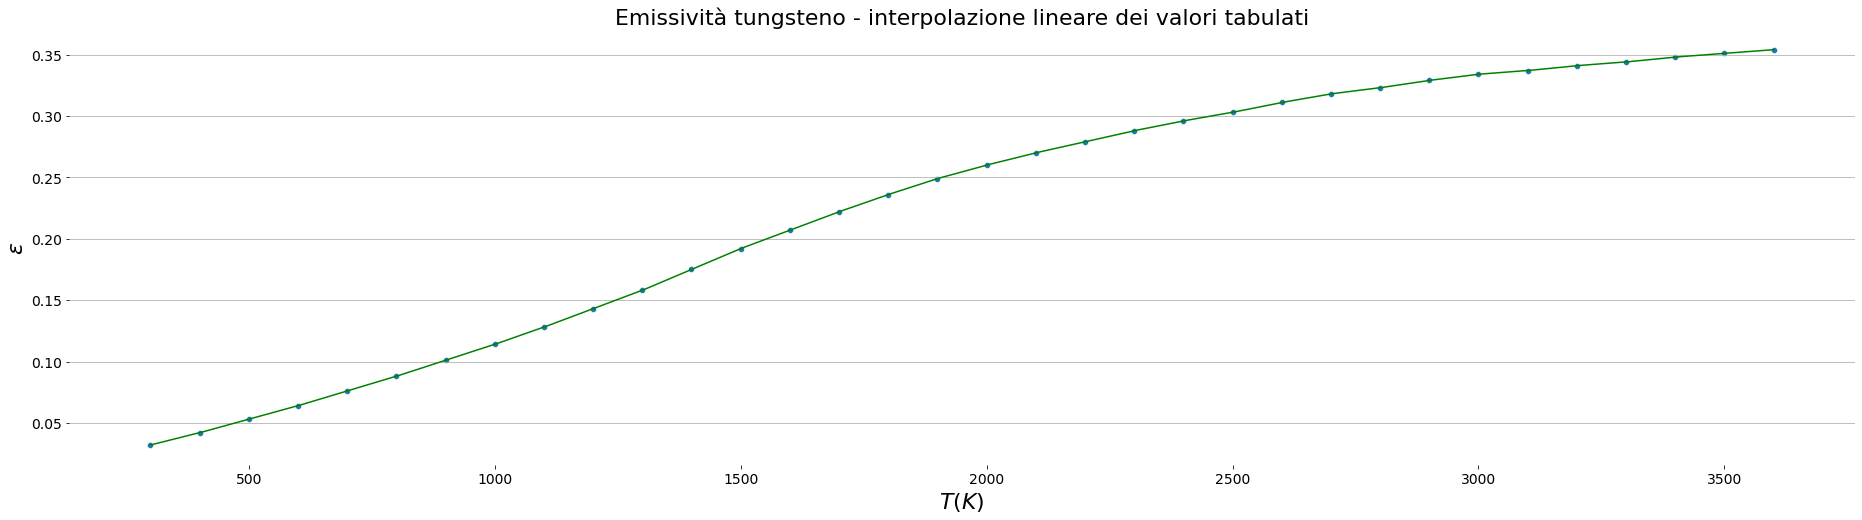

In [8]:
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
sns.scatterplot(x=t0, y=e0, ax=ax1)
x=np.linspace(t0.min(), t0.max(),1000)
y=emissività(x)
sns.lineplot(x=x, y=y, ax=ax1, color='green')
ax1.set_xlabel(r'$T(K)$', fontsize = 22)
ax1.set_ylabel(r"$\epsilon$", fontsize = 22)
ax1.set_title('Emissività tungsteno - interpolazione lineare dei valori tabulati', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('emissivita.svg', bbox_inches = "tight")

In [9]:
lam=520e-9 #lunghezza d'onda selezionata dal filtro
err_lam=20e-9 #errore lunghezza d'onda semiampiezza della banda passante del filtro
freq=c/lam
err_freq=c/lam**2*err_lam
l1=4.27e-3 #lato lungo
err_l1=200e-6
l2=1.1e-3 #lato corto
err_l2=200e-6
s=325e-6 #spessore
err_s=25e-6 #errore sperrore dato dallo spessimetro
n=19.5 #numero di spire
A=n*np.pi*s*2*(l1+l2) #area
err_A=np.sqrt((A/s*err_s)**2+(A/(l1+l2)*err_l1)**2+(A/(l1+l2)*err_l2)**2)

In [10]:
def temperatura(potenza, emissività=emissività, A=A, sigma=st, epsilon=1e-6):
    e=1
    T=0
    temp=100
    while np.abs((temp:=(potenza/e/A/sigma)**(1/4)) - T)>epsilon:
        e=emissività(temp)
        T=temp
    return T, e

In [11]:
df=df.join(pd.DataFrame.from_records(df['potenza'].apply(temperatura), columns=['T','emissività']))

In [12]:
def calcolo_h(el1, el2, c=c, freq=freq, err_freq=err_freq, A=A, err_A=err_A):
    h=15*c**2/2/np.pi**5/A/freq**4 * el1[1]*el2[1]/((el2[2]*el1[1])**(1/4) - (el1[2]*el2[1])**(1/4))**4 * (np.log(el1[0]/el2[0])-np.log(el1[2]/el2[2]))**4
    da=h/A*err_A
    dp1=h/el1[1]*(el1[2]*el2[1])**(1/4)/((el2[2]*el1[1])**(1/4) - (el1[2]*el2[1])**(1/4))*el1[3]
    dp2=h/el2[1]*(el2[2]*el1[1])**(1/4)/((el2[2]*el1[1])**(1/4) - (el1[2]*el2[1])**(1/4))*el2[3]
    dj1=4*h/el1[0]/(np.log(el1[0]/el2[0])-np.log(el1[2]/el2[2]))*el1[4]
    dj2=4*h/el2[0]/(np.log(el1[0]/el2[0])-np.log(el1[2]/el2[2]))*el2[4]
    dfreq=4*h/freq*err_freq
    err_h=np.sqrt(da**2 + dp1**2 + dp2**2 + dj1**2 + dj2**2 + dfreq**2)
    return h, err_h

In [13]:
hs=np.array([(calcolo_h(*comb)[0], calcolo_h(*comb)[1], comb[0][0], comb[1][0]) for comb in combinations(df[['vpd', 'potenza', 'emissività', 'err_p', 'err_vpd']].to_numpy(),2)])
hs=pd.DataFrame(hs, columns=['h', 'err_h', 'j1', 'j2'])

<Axes: ylabel='h'>

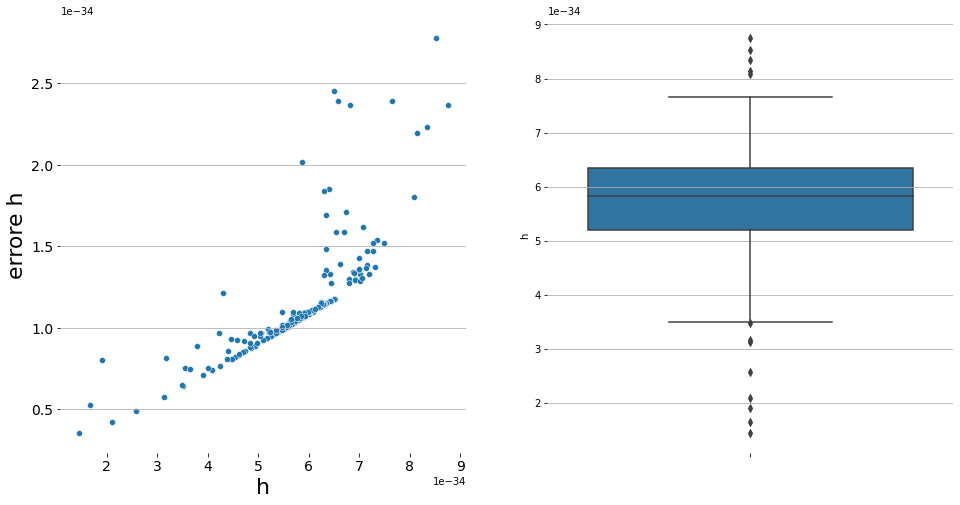

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (16,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xlabel('h', fontsize = 22)
ax1.set_ylabel("errore h", fontsize = 22)
ax1.tick_params(axis='both', which='major', labelsize=14)
sns.scatterplot(hs, x='h', y='err_h', ax=ax1)
ax2.grid(axis = 'y')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=14)
sns.boxplot(hs,y='h', ax=ax2)
#plt.savefig('emissività.svg', bbox_inches = "tight")

In [15]:
hs['err_rel']=hs['err_h']/hs['h']
hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   h        171 non-null    float64
 1   err_h    171 non-null    float64
 2   j1       171 non-null    float64
 3   j2       171 non-null    float64
 4   err_rel  171 non-null    float64
dtypes: float64(5)
memory usage: 6.8 KB


In [16]:
hs.describe()

,h,err_h,j1,j2,err_rel
count,1.710000e+02,1.710000e+02,171.000000,171.000000,171.000000
mean,5.723189e-34,1.153133e-34,1.563676,0.466713,0.201203
std,1.207958e-34,3.772943e-35,0.974321,0.537513,0.040868
min,1.445841e-34,3.548666e-35,0.073700,0.053000,0.180461
25%,5.202540e-34,9.710384e-35,0.648000,0.102100,0.181590
50%,5.836526e-34,1.076493e-34,1.440000,0.233000,0.184483
75%,6.347425e-34,1.274848e-34,2.350000,0.648000,0.196404
max,8.755616e-34,2.780720e-34,3.230000,2.760000,0.419258


In [17]:
h_medio=np.average(hs['h'], weights=hs['err_h']**-2)
err_h_medio=np.sqrt(1/((hs['err_h']**-2).sum()))
print(f'media pesata di h: {h_medio} ± {err_h_medio}')

media pesata di h: 4.927233336844137e-34 ± 7.663258728715825e-36


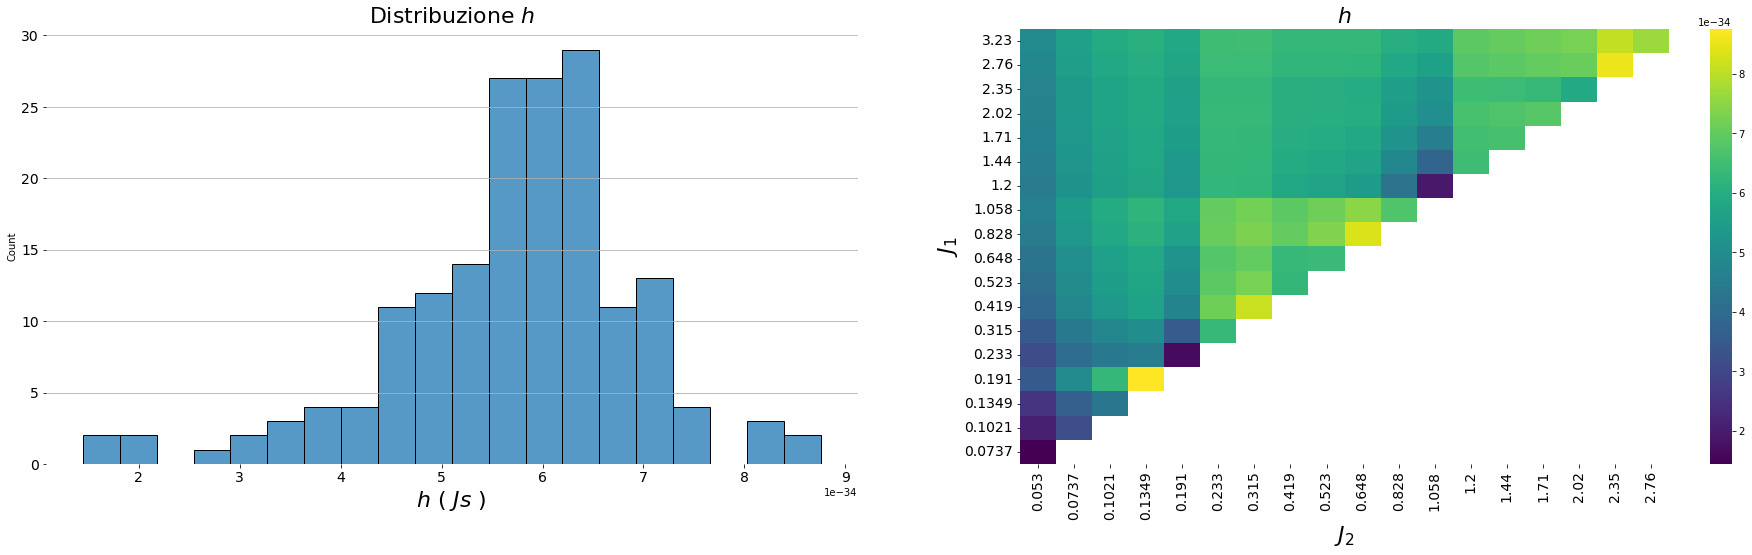

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (32,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
sns.histplot(hs['h'], ax=ax1, bins=20)
ax1.set_xlabel(r'$h\ (\ Js\ )$', fontsize = 22)
ax1.set_title('Distribuzione $h$', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
sns.heatmap(hs.pivot(index='j1', columns='j2', values='h').sort_index(ascending=False), ax=ax2, cmap='viridis')
ax2.set_xlabel(r'$J_2$', fontsize = 22)
ax2.set_ylabel(r'$J_1$', fontsize = 22)
xticks=ax2.get_xticks()
xlabels=ax2.get_xticklabels()
ax2.set_xticks(xticks, labels=xlabels, rotation=90)
ax2.set_title('$h$', fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('grafico_h_pulito.svg', bbox_inches = "tight")